# Parameterizing Neural Power Spectra

SfN 2018 NanoSymposium: Oscillation Methods

Thomas Donoghue

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

from neurodsp.sim import sim_noisy_bursty_oscillator, sim_noisy_oscillator
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF
from fooof.utils import trim_spectrum
from fooof.synth import gen_power_spectrum
from fooof.analysis import get_band_peak
from fooof.plts.spectra import plot_spectrum, plot_spectra, plot_spectrum_shading, plot_spectra_shading

### Neural Time Series

In [2]:
# Set the random seed for simulations
import numpy as np
np.random.seed(17)

In [3]:
# Generate a noisy oscillation signal, 3 seconds of 10Hz, sampled @ 1000 Hz
n_seconds, s_rate = 10, 1000
osc_freq, noise_exp = 10, -2
signal = sim_noisy_bursty_oscillator(n_seconds=n_seconds, fs=s_rate, freq=osc_freq, exponent=noise_exp,
                                      ratio_osc_power=2.5, prob_enter_burst=0.3)

In [4]:
def plot_time_series(signal):
    time_series_plot = plt.figure(figsize=[18, 6])
    plt.plot(signal, color='#21437a')
    plt.xlim([0, 5000]);
    ax = plt.gca()
    ax.set_axis_off()

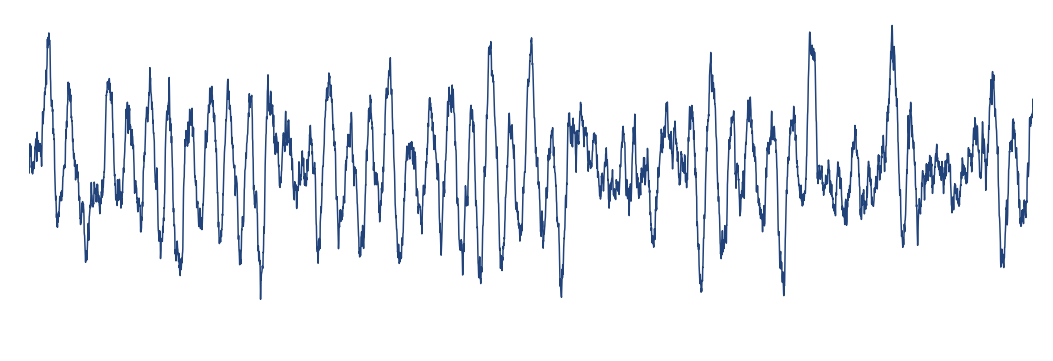

In [5]:
plot_time_series(signal)

## Neural Power Spectra

In [6]:
# Create a power spectrum of our signal
freqs, powers = compute_spectrum(signal, s_rate)

In [7]:
# Trim spectrum to be only between 3 & 40 Hz
freqs, powers = trim_spectrum(freqs, powers, [3, 40])

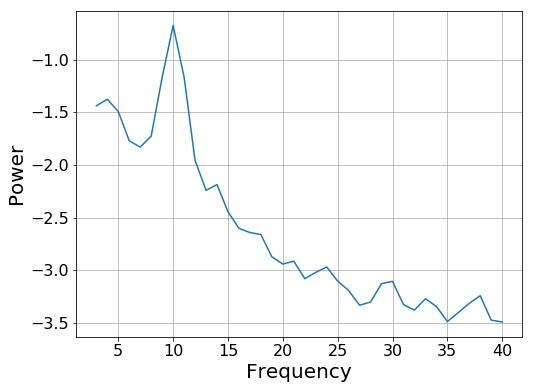

In [8]:
plot_spectrum(freqs, powers, log_freqs=False, log_powers=True, ax=plt.figure(figsize=[8, 6]).gca()) 

## Analysis: Measure Band Specific Power

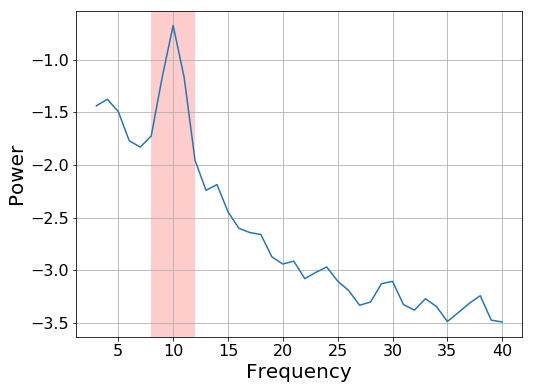

In [9]:
plot_spectrum_shading(freqs, powers, [8, 12], log_powers=True, ax=plt.figure(figsize=[8, 6]).gca()) 

In [10]:
# Generation Settings
nlv = 0
f_res = 0.1
f_range = [3, 30]

# Create base line power spectrum
fs, ps_base = gen_power_spectrum(f_range, [0, 1.5], [[10, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)

# Create comparison power spectra
_, ps_ap = gen_power_spectrum(f_range, [0, 1.5],   [[10, 0.31, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)
_, ps_af = gen_power_spectrum(f_range, [0, 1.5],   [[11.75, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)
_, ps_of = gen_power_spectrum(f_range, [-0.125, 1.5], [[10, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)
_, ps_sl = gen_power_spectrum(f_range, [-0.87, 0.75],   [[10, 0.5, 1], [22, 0.2, 2]], nlv=nlv, freq_res=f_res)

## Comparing Oscillatory Band Power

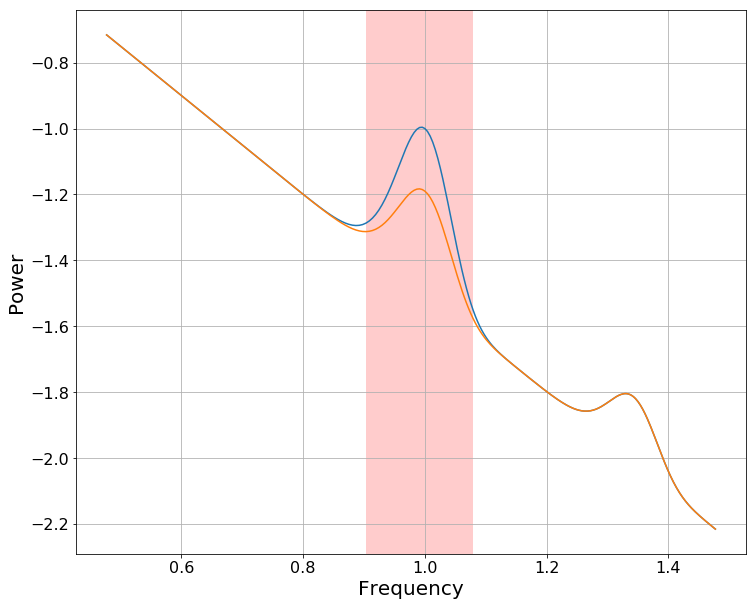

In [11]:
plot_spectra_shading(fs, [ps_base, ps_ap], [8, 12], log_freqs=True, log_powers=True)

In [12]:
def comparison_fig():
    title_settings = {'fontsize' : 20}

    comparison_fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    plot_spectra_shading(fs, [ps_base, ps_ap], [8, 12], log_freqs=True, log_powers=True, ax=ax[0, 0])
    ax[0, 0].set_title('Alpha Power Decrease', **title_settings)
    plot_spectra_shading(fs, [ps_base, ps_af], [8, 12], log_freqs=True, log_powers=True, ax=ax[0, 1])
    ax[0, 1].set_title('Alpha Frequency Shift', **title_settings)
    plot_spectra_shading(fs, [ps_base, ps_of], [8, 12], log_freqs=True, log_powers=True, ax=ax[1, 0])
    ax[1, 0].set_title('Offset Shift', **title_settings)
    plot_spectra_shading(fs, [ps_base, ps_sl], [8, 12], log_freqs=True, log_powers=True, ax=ax[1, 1])
    ax[1, 1].set_title('Slope Rotation', **title_settings)

    # Drop axis labels 
    for aa in ax.reshape(-1): 
        aa.xaxis.label.set_visible(False)
        aa.yaxis.label.set_visible(False)

    comparison_fig.subplots_adjust(hspace=.2)
    comparison_fig.subplots_adjust(wspace=.3)

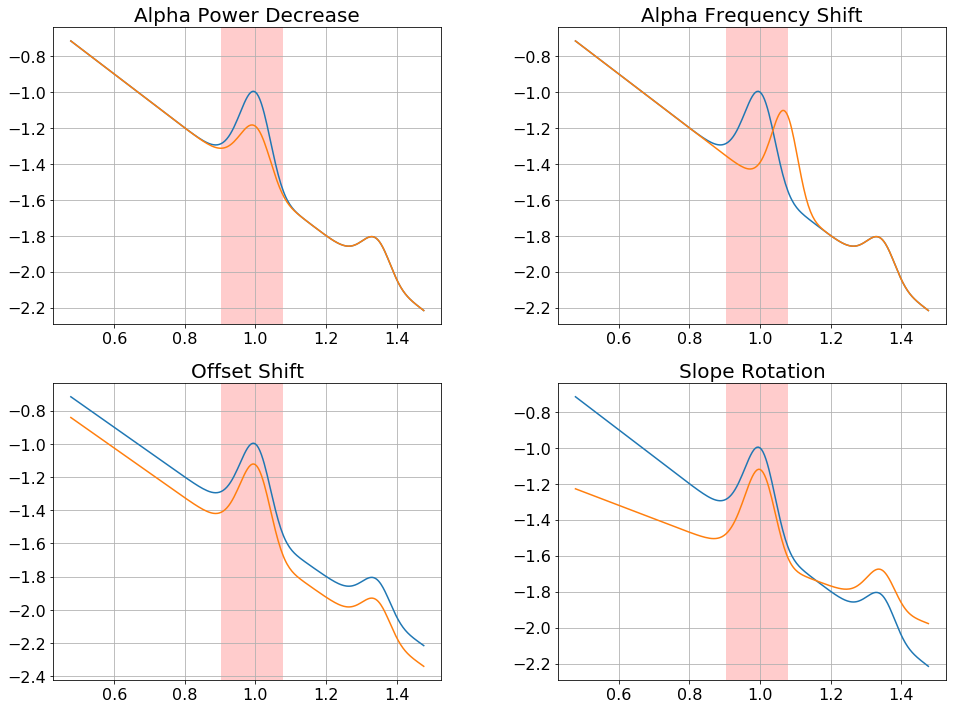

In [13]:
comparison_fig()

## No Oscillations at all

<center><img src="img/no_oscillations.png" width="1000px"></center>

## Time Series & Filters

<center><img src="img/filters.png" width="1000px"></center>

<center><img src="img/procedure.png" width="800px"></center>

## FOOOF in Code

In [14]:
# Initialize & fit FOOOF model
fm = FOOOF(verbose=False)
fm.fit(freqs, powers)

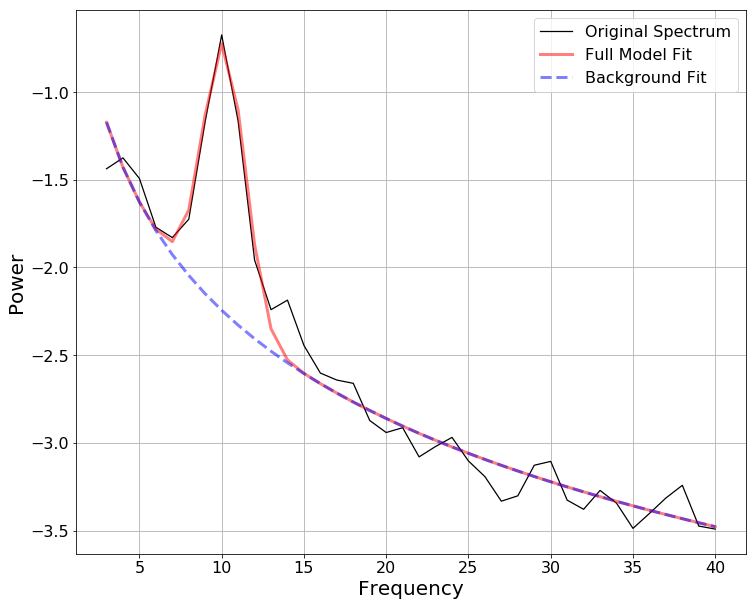

In [15]:
# Plot model fit results
fm.plot()

In [16]:
# Print out the quantitative model fit results
fm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.1947, 2.0493                                          
                                                                                                  
                                       1 peaks were found:                                        
          

## Revisiting Slope Changes

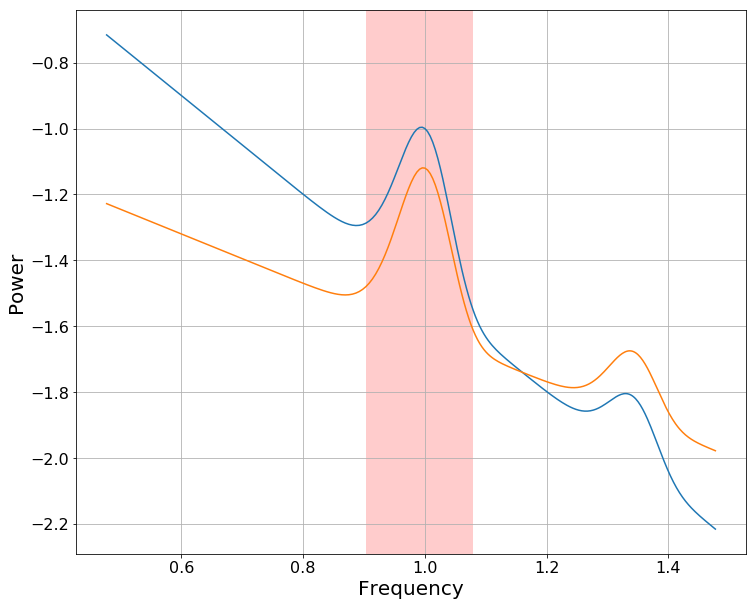

In [17]:
plot_spectra_shading(fs, [ps_base, ps_sl], [8, 12], log_freqs=True, log_powers=True)

## Fitting FOOOF Models

In [18]:
# Initialize FOOOF models
fm1, fm2 = FOOOF(), FOOOF()

In [19]:
# Fit FOOOF models
fm1.fit(fs, ps_base)
fm2.fit(fs, ps_sl)

## Comparing FOOOF Ouputs

In [20]:
def print_periodic(fms, band):
    
    print('Model Fit Periodic Parameters\n')
    for ind, fm in enumerate(fms):
        print('PSD-{}:\tCF: {:1.2f} \tAMP: {:1.2f} \tBW: {:1.2f}'.format(
            ind, *get_band_peak(fm1.peak_params_, [8, 12])))

def print_aperiodic(fms):
    
    print('Model Fit Aperiodic Parameters\n')
    for ind, fm in enumerate(fms):
        print('PSD-{}:\tOffset: {:1.2f} \t\t1/f Slope: {:1.2f}'.format(
            ind, *fm.background_params_))

In [21]:
# Compare periodic components - for alpha
print_periodic([fm1, fm2], [8, 12])

Model Fit Periodic Parameters

PSD-0:	CF: 10.00 	AMP: 0.49 	BW: 1.93
PSD-1:	CF: 10.00 	AMP: 0.49 	BW: 1.93


In [22]:
# Compare aperiodic component
print_aperiodic([fm1, fm2])

Model Fit Aperiodic Parameters

PSD-0:	Offset: -0.01 		1/f Slope: 1.49
PSD-1:	Offset: -0.88 		1/f Slope: 0.74


## Why Use FOOOF?

- It fully parameterizes the power spectra
- Does not require prior specification of oscillation bands
- Explicitly controls for confounds between periodic & aperiodic components

<center><img src="img/megmapping.png" width="800px"></center>

## Ongoing Projects: Methods

- Comparing to Other Measures
    - Periodic Features: Analytic Amplitude, Band Ratios, etc
    - Aperiodic Measures: DFA, IRASA, etc.

## Ongoing Projects: Applications


- Descriptive Work
    - EEG & MEG Mapping
- Trial-by-trial Analysis
    - Improved behavioural decoding with parameterized spectra
- Neuro-Data-Science
    - Systematic integration with other spatially quantified measures

## FOOOF Application: Poster Sunday am

<center><img src="img/LuyandaMdanda.png" width="200px"></center>

<center><img src="img/mdanda_poster.png" width="800px"></center>

<center><img src="img/acknowledgements.png" width="800px"></center>

<center><h1>Try it Out!</h1></center>

<br>

<center><h2>This Presentation: https://github.com/fooof-tools/presentations</h2></center>

<br>

<center><h2>FOOOF: https://github.com/fooof-tools/fooof</h2></center>

<br>

<center><h2>Contact: tdonoghue@ucsd.edu</h2></center>
<center><h2>https://tomdonoghue.github.io</h2></center>
<center><h3>Github & Twitter: @TomDonoghue</h3></center>
<br>